In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd

# 1

In [29]:
# calculate the pair-wise acceleration and energy
def getAcc(pos : np.ndarray, mass : np.ndarray, G : float, softening : float):
    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]
    
    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z
    
    # matrix that stores 1/r^3 for all particle pairwise particle separations 
    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)**(-1.5)
    
    ax = G * (dx * inv_r3) @ mass
    ay = G * (dy * inv_r3) @ mass
    az = G * (dz * inv_r3) @ mass
    
    # pack together the acceleration components
    a = np.hstack((ax,ay,az))

    return a

# calculate the energy in one timestep
def getEnergy( pos:np.ndarray, vel:np.ndarray, mass:np.ndarray, G :float):
    # Kinetic Energy:
    KE = 0.5 * np.sum(np.sum( mass * vel**2 ))

    

    # position vectors
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

    # pair-wise distance in 3 dimensions
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r for all particle pairwise particle separations 
    inv_r = np.sqrt(dx**2 + dy**2 + dz**2)
    inv_r[inv_r>0] = 1.0/inv_r[inv_r>0]

    # sum over upper triangle, to count each interaction only once
    PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r,1)))
    
    return KE, PE

# leapfrog based on acceleration
def leapfrog(pos: np.ndarray, vec: np.ndarray, mass: np.ndarray, G: float, softening: float, dt: float):

    # leapfrog for N-body
    vec = vec + 0.5*dt*getAcc(pos, mass, G, softening)
    pos = pos+ vec*dt
    vec = vec+ 0.5*dt*getAcc(pos, mass, G, softening)

    KE, PE = getEnergy(pos, vec, mass, G)

    return pos, vec, KE, PE

In [30]:
# Data and constants
plummer_data_1a = pd.read_csv('plummer_regular.csv')
softening = np.median(plummer_data_1a.loc[:,'r'].to_numpy()) * 0.1
r = plummer_data_1a.loc[:,['r_x', 'r_y', 'r_z']]
r = r.to_numpy()
v = plummer_data_1a.loc[:,['v_x', 'v_y', 'v_z']]
v = v.to_numpy()
mass = np.full((10000,1), 2)/1e11

length_unit = 1.5 # kpc
vec_unit = 5.477e-7 # kpc/year
M_unit = 1e11 # Msolar
G = 6.67 * 10**(-8) * (1.02*10**(-14))**2 * (3.24*10**-22) * (1.989*10**(33)) # kpc^3/(Msolar*year**2)

# scale with length
r = r*length_unit
v = v*vec_unit
mass = M_unit*mass

# simulation time
T = 50
dt = 1
step = T/dt

# result container
pos_out = []
vec_out = []
KE_out = []
PE_out = []

In [31]:
# simulate for 50 time step
for i in range(int(step)):
    r, v, KE, PE = leapfrog(r, v, mass, G = G, softening = softening, dt = dt)
    pos_out.append(r)
    vec_out.append(v)
    KE_out.append(KE)
    PE_out.append(PE)

pos_out = np.array(pos_out)
vec_out = np.array(vec_out)
KE_out = np.array(KE_out)
PE_out = np.array(PE_out)
TE_out = KE_out + PE_out # total energy

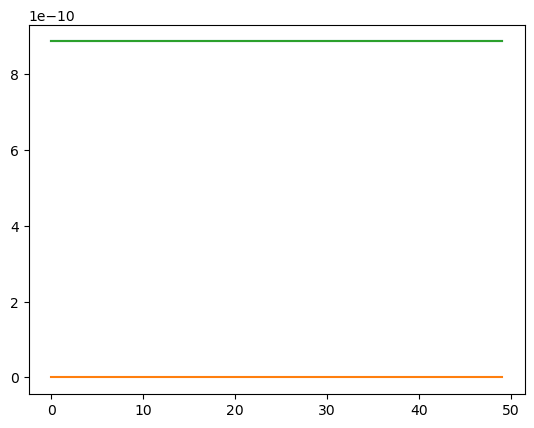

In [32]:
time = np.arange(50)
plt.plot(time, KE_out)
plt.plot(time, PE_out)
plt.plot(time, TE_out)
plt.show()

# 2

In [34]:
# Data and constants
# same position but zero initial velocity
softening = np.median(plummer_data_1a.loc[:,'r'].to_numpy()) * 0.1
r = plummer_data_1a.loc[:,['r_x', 'r_y', 'r_z']]
r = r.to_numpy()
v = plummer_data_1a.loc[:,['v_x', 'v_y', 'v_z']]
v = v.to_numpy()
v[True] = 0 # set initial velocity to 0
mass = np.full((10000,1), 2)/1e11

length_unit = 1.5 # kpc
vec_unit = 5.477e-7 # kpc/year
M_unit = 1e11 # Msolar
G = 6.67 * 10**(-8) * (1.02*10**(-14))**2 * (3.24*10**-22) * (1.989*10**(33)) # kpc^3/(Msolar*year**2)

# scale with length
r = r*length_unit
v = v*vec_unit
mass = M_unit*mass

# simulation time
T = 50
dt = 1
step = T/dt

# result container
pos_out = []
vec_out = []
KE_out = []
PE_out = []

In [35]:
# simulate for 50 time step
for i in range(int(step)):
    r, v, KE, PE = leapfrog(r, v, mass, G = G, softening = softening, dt = dt)
    pos_out.append(r)
    vec_out.append(v)
    KE_out.append(KE)
    PE_out.append(PE)

pos_out = np.array(pos_out)
vec_out = np.array(vec_out)
KE_out = np.array(KE_out)
PE_out = np.array(PE_out)
TE_out = KE_out + PE_out # total energy

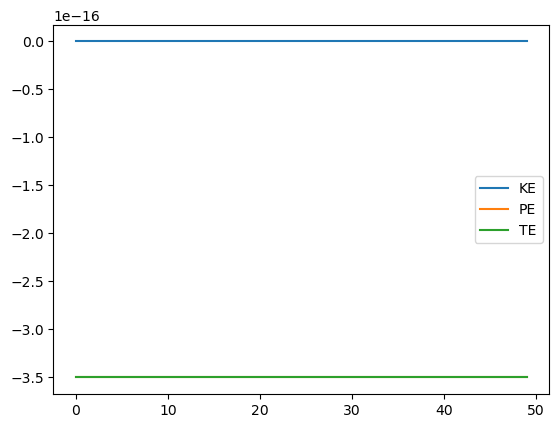

In [41]:
time = np.arange(50)
plt.plot(time, KE_out, label = 'KE')
plt.plot(time, PE_out, label = 'PE')
plt.plot(time, TE_out, label = 'TE')
plt.legend()
plt.show()

# 3

In [37]:
# # Create the figure and axes for the plot
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')

# # Create the initial point in the plot
# point1, = ax.plot(pos_out[0,:,0], pos_out[0,:,1], pos_out[0,:,2], 'bo')

# # Define the update function for the animation
# def update(frame):

#     point1.set_data(pos_out[frame][:,0], pos_out[frame][:,1])
#     point1.set_3d_properties(pos_out[frame][:,2])

#     return point1,

# # Create the animation object
# anim = FuncAnimation(fig, update, frames = int(step))

# ax.set_title('part 1')
# plt.show()

A few important things to note about this project so far: <br> 1: the total energy seems conserved as the value does not change along the simulation of 50 time steps. However, this might due to the fact that the unit scales (time scale) is too small that real time analysis cannot be reflected. <br> 2: I tried inrease the step size for the simulation. However, due to the number of particles in this project, it takes a tremendous amount of time to simulate. In the correction version, I thought to utilize pytorch to use the gpu to maybe achieve speed up of the computation to increase the total amount of time step simulated. <br> 3: the matplotlib animation was throwing wired error. The code was totally working fine for the previous animation. The input data type and structure are also the same. One cause for the error of maplotlib animation is maybe due to the large number of particles. I ought to look into the animation in the correction version and produce the galaxy collapsing mp4 file to demonstrate the behavour.